In [1]:
from datetime import datetime
import os
import tempfile
from glob import glob
from pathlib import Path
this_path = Path().resolve()
from sklearn.model_selection import train_test_split
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from torch.utils import tensorboard

from torch.utils.data import random_split, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import monai
import torchmetrics
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ResizeWithPadOrCrop,
    RandAdjustContrast,
    RandBiasField,
    RandAffine,
    ScaleIntensity,
)
import pandas as pd
import torchio as tio
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml
import nibabel as nib

from dataset.ppmi_dataset import PPMIDataModule
from dataset.hmri_dataset import HMRIDataModule
from models.pl_model import Model
from utils.utils import get_data_and_model, predict_from_ckpt

2023-03-15 10:09:16,821 - Created a temporary directory at /tmp/tmppcvsscat
2023-03-15 10:09:16,822 - Writing /tmp/tmppcvsscat/_remote_module_non_scriptable.py
/home/alejandrocu/Documents/parkinson_classification/models/medicalnet


In [6]:
ckpt_path = '/home/alejandrocu/Documents/parkinson_classification/p1_hmri_outs/brainhmri3dresnet-da02_bz3_focal_adam_lr0.001/version_0/checkpoints/epoch=49-val_auroc=0.7959.ckpt'

# read config file
exp_dir = Path(ckpt_path).parent.parent.parent
with open(exp_dir /'config_dump.yml', 'r') as f:
    cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

root_dir = Path('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
data = HMRIDataModule(md_df=md_df, root_dir=root_dir, **cfg['dataset']) #shuffle=False
data.prepare_data()
data.setup()

Drop subjects ['sub-058', 'sub-016', 'sub-025']


In [7]:
data.md_df_val

,id,s01-7t,s01-3t,s02-7t,s03-7t,group
43,sub-048,True,True,True,True,0
39,sub-044,True,True,True,True,0
62,sub-068,True,True,False,False,0
55,sub-061,True,True,True,True,1
56,sub-062,True,True,False,False,1
10,sub-013,True,True,False,False,1
48,sub-053,True,True,False,False,1
65,sub-071,True,True,True,True,1
16,sub-020,True,True,True,True,0
50,sub-055,True,True,False,False,1


In [2]:
ckpt_path = '/home/alejandrocu/Documents/parkinson_classification/p1_hmri_outs/brainhmri3dresnet-da02_bz3_focal_adam_lr0.001/version_0/checkpoints/epoch=49-val_auroc=0.7959.ckpt'
data, model = get_data_and_model(ckpt_path=Path(ckpt_path), dataset='hmri')


# y_hat, _ = predict_from_ckpt(ckpt_path=Path(ckpt_path), 
#                              dataloader='val',
#                              return_preds=False, dataset='hmri')
dl = data.val_dataloader()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.net.to(device)

RuntimeError: CUDA error: out of memory

In [5]:
data.train_set[0]['image']['path']

"[PosixPath('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI/sub-074/Results/sub-074_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_MTsat_w.nii'), PosixPath('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI/sub-074/Results/sub-074_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_PD_R2scorr_w.nii'), PosixPath('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI/sub-074/Results/sub-074_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_R1_w.nii'), PosixPath('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI/sub-074/Results/sub-074_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_R2s_WLS1_w.nii')]"

In [6]:
input, label = data.val_set[0]['image'], data.val_set[0]['label']

In [9]:
label

tensor([0., 1.])

In [7]:
data.md_df_val

,id,s01-7t,s01-3t,s02-7t,s03-7t,group
59,sub-063,True,True,False,False,1
64,sub-068,True,True,False,False,0
43,sub-046,True,True,False,False,1
20,sub-023,True,True,False,False,1
8,sub-011,True,True,False,False,1
17,sub-020,True,True,True,True,0
11,sub-014,True,True,False,False,1
67,sub-071,True,True,True,True,1
55,sub-059,True,True,True,True,1
42,sub-045,True,True,True,True,1


In [4]:
data.md_df_val['y_hat'] = y_hat
data.md_df_val 

,id,s01-7t,s01-3t,s02-7t,s03-7t,group,y_hat
59,sub-063,True,True,False,False,1,1
64,sub-068,True,True,False,False,0,1
43,sub-046,True,True,False,False,1,1
20,sub-023,True,True,False,False,1,1
8,sub-011,True,True,False,False,1,1
17,sub-020,True,True,True,True,0,0
11,sub-014,True,True,False,False,1,1
67,sub-071,True,True,True,True,1,1
55,sub-059,True,True,True,True,1,1
42,sub-045,True,True,True,True,1,1


In [3]:
dl[5]

TypeError: 'DataLoader' object is not subscriptable

In [3]:
for subjects_batch in dl:
    inputs = subjects_batch['image'][tio.DATA]
    target = subjects_batch['label']
    break
print(type(inputs), inputs.shape, target, target.shape)

<class 'torch.Tensor'> torch.Size([5, 4, 200, 200, 200]) tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.]]) torch.Size([5, 2])


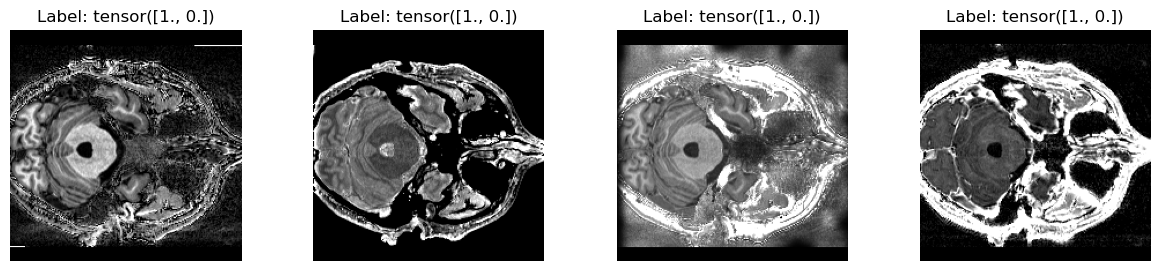

In [19]:
subj = 1
f,axs = plt.subplots(1,4, figsize=(15, 3))
for i in range(4):
    axs[i].imshow(inputs[subj].cpu().detach().numpy()[i, :, :, 80], cmap='gray')
    axs[i].set_title(f'Label: {target[subj]}')
    axs[i].axis('off')

In [5]:
# pd subject, slice 105
pd_img, pd_label = inputs[0].unsqueeze(0).to(device), target[0].to(device)
print(pd_img.shape, pd_label)

torch.Size([1, 4, 200, 200, 200]) tensor([0., 1.], device='cuda:0')


In [6]:
# hc subject, slice 85
hc_img, hc_label = inputs[1].unsqueeze(0).to(device), target[1].to(device)
print(hc_img.shape, hc_label)

torch.Size([1, 4, 200, 200, 200]) tensor([1., 0.], device='cuda:0')


In [7]:
# Get the occlusion sensitivity map

occ_sens = monai.visualize.OcclusionSensitivity(nn_module=model.net, mask_size=10, n_batch=10, overlap=0.25)
# Only get a single slice to save time.
# For the other dimensions (channel, width, height), use
# -1 to use 0 and img.shape[x]-1 for min and max, respectively
# (minC,maxC,minD,maxD,minH,maxH,minW,maxW)
depth_slice = 100
occ_sens_b_box = [-1, -1, -1, -1, depth_slice - 1, depth_slice]

occ_result, mpclass = occ_sens(x=pd_img, b_box=occ_sens_b_box)
# occ_result_s = occ_result[0, pd_label.argmax().item()][None]

100%|██████████| 85/85 [01:15<00:00,  1.12it/s]


In [34]:
occ_result[0, pd_label.argmax().item()].shape

torch.Size([200, 200, 1])

In [42]:
np.unique(np.asarray(mpclass.cpu()), return_counts=True)

(array([1]), array([40000]))

In [ ]:
# save the results
out_dir = Path('/home/alejandrocu/Documents/parkinson_classification/occ_sens') / ckpt_path.parent.parent.parent.name
out_dir.mkdir(parents=True, exist_ok=True)
with open(out_dir / 'occ_result.npy', 'wb') as f:
    np.save(f, occ_result)
with open(out_dir / 'mpclass.npy', 'wb') as f:
    np.save(f, mpclass)

In [37]:
pd_img.shape

torch.Size([1, 4, 200, 200, 200])

In [33]:
with open('/home/alejandrocu/Documents/parkinson_classification/occ_sens/hmri3dresnet-da01_bz5_BCE_adam_lr0.001_windowed_r42-2/occ_result.npy', 'rb') as f:
    a = np.load(f)
a.shape

(1, 2, 200, 200, 200)

In [36]:
type(occ_result)

monai.data.meta_tensor.MetaTensor

In [53]:
occ_result_s = occ_result[0, 0][..., 0]
print(occ_result_s.shape)

torch.Size([200, 200])


In [14]:
mpclass.shape

torch.Size([1, 1, 200, 200, 1])

In [9]:
occ_result[0, 1][..., 0].shape

torch.Size([200, 200])

In [11]:
pd_img[0, 0, ..., depth_slice].shape

torch.Size([200, 200])

In [70]:
def overlay_mask_on_image(image, mask, alpha=0.5, cmap='jet'):
    """Overlay a mask on top of an image.
    Args:
        image: image to be overlaid, shape (C, H, W)
        mask: mask to be overlaid, shape (H, W)
        alpha: transparency of the mask
        cmap: colormap to use for the mask
    """
    image = image[0, ...]
    mask = mask[0, ...]
    mask = np.ma.masked_where(mask == 0, mask)
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap=cmap, alpha=alpha)

In [78]:
ex_mask.shape

(200, 200)

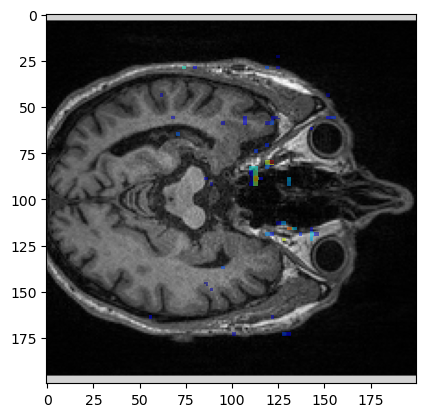

In [82]:
occ_result_s = occ_result[0, 1][..., 0]
ex_mask = occ_result_s.cpu().detach()
# ex_mask[ex_mask >= 0.8975] = 1
ex_mask[ex_mask < 0.8974] = 0
overlay_mask_on_image(pd_img[0, ..., 105].detach().cpu().numpy(), ex_mask.unsqueeze(0))



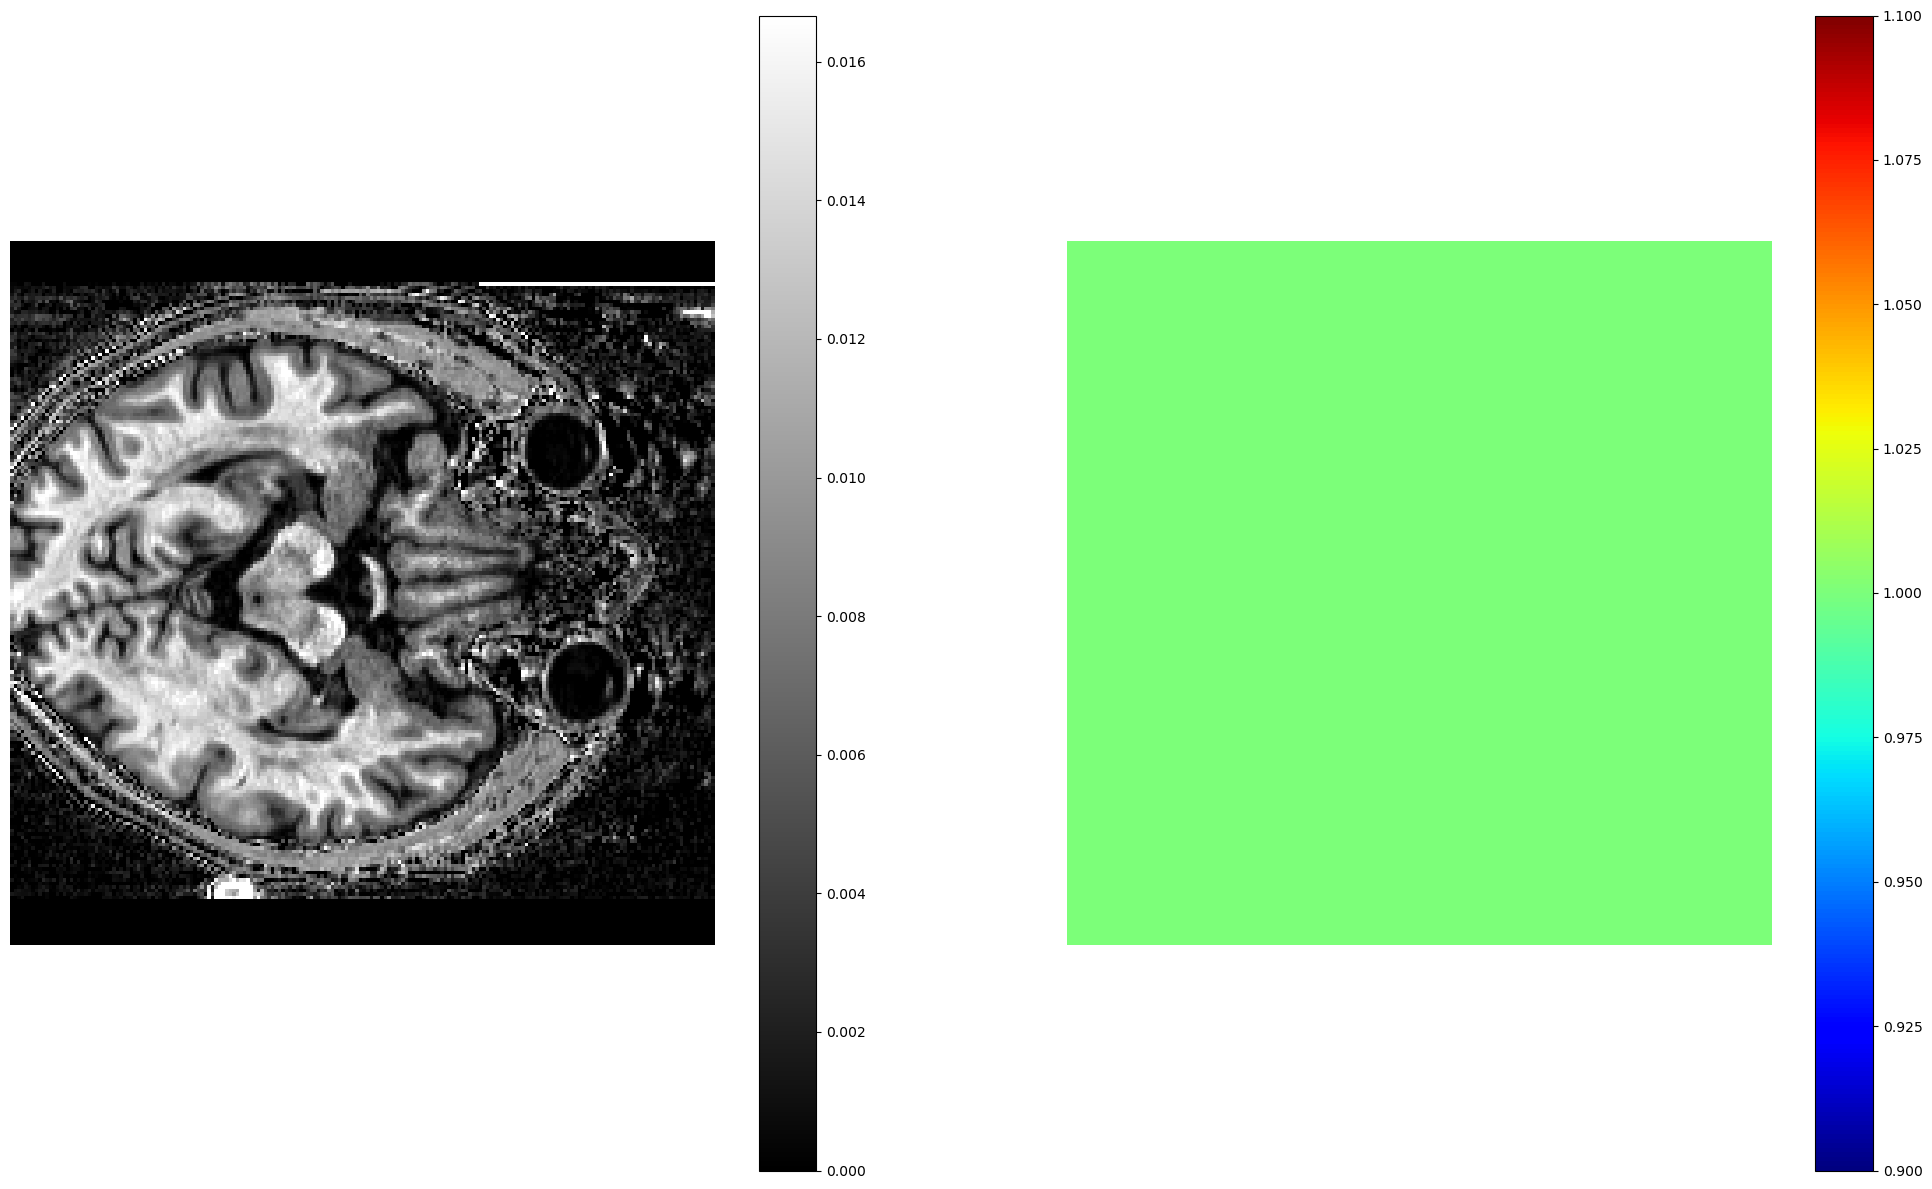

In [15]:
# mpclass
occ_result_s = mpclass[0, 0][..., 0]
fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([pd_img[0, 0, ..., depth_slice].unsqueeze(0).unsqueeze(0), occ_result_s.unsqueeze(0).unsqueeze(0)]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)

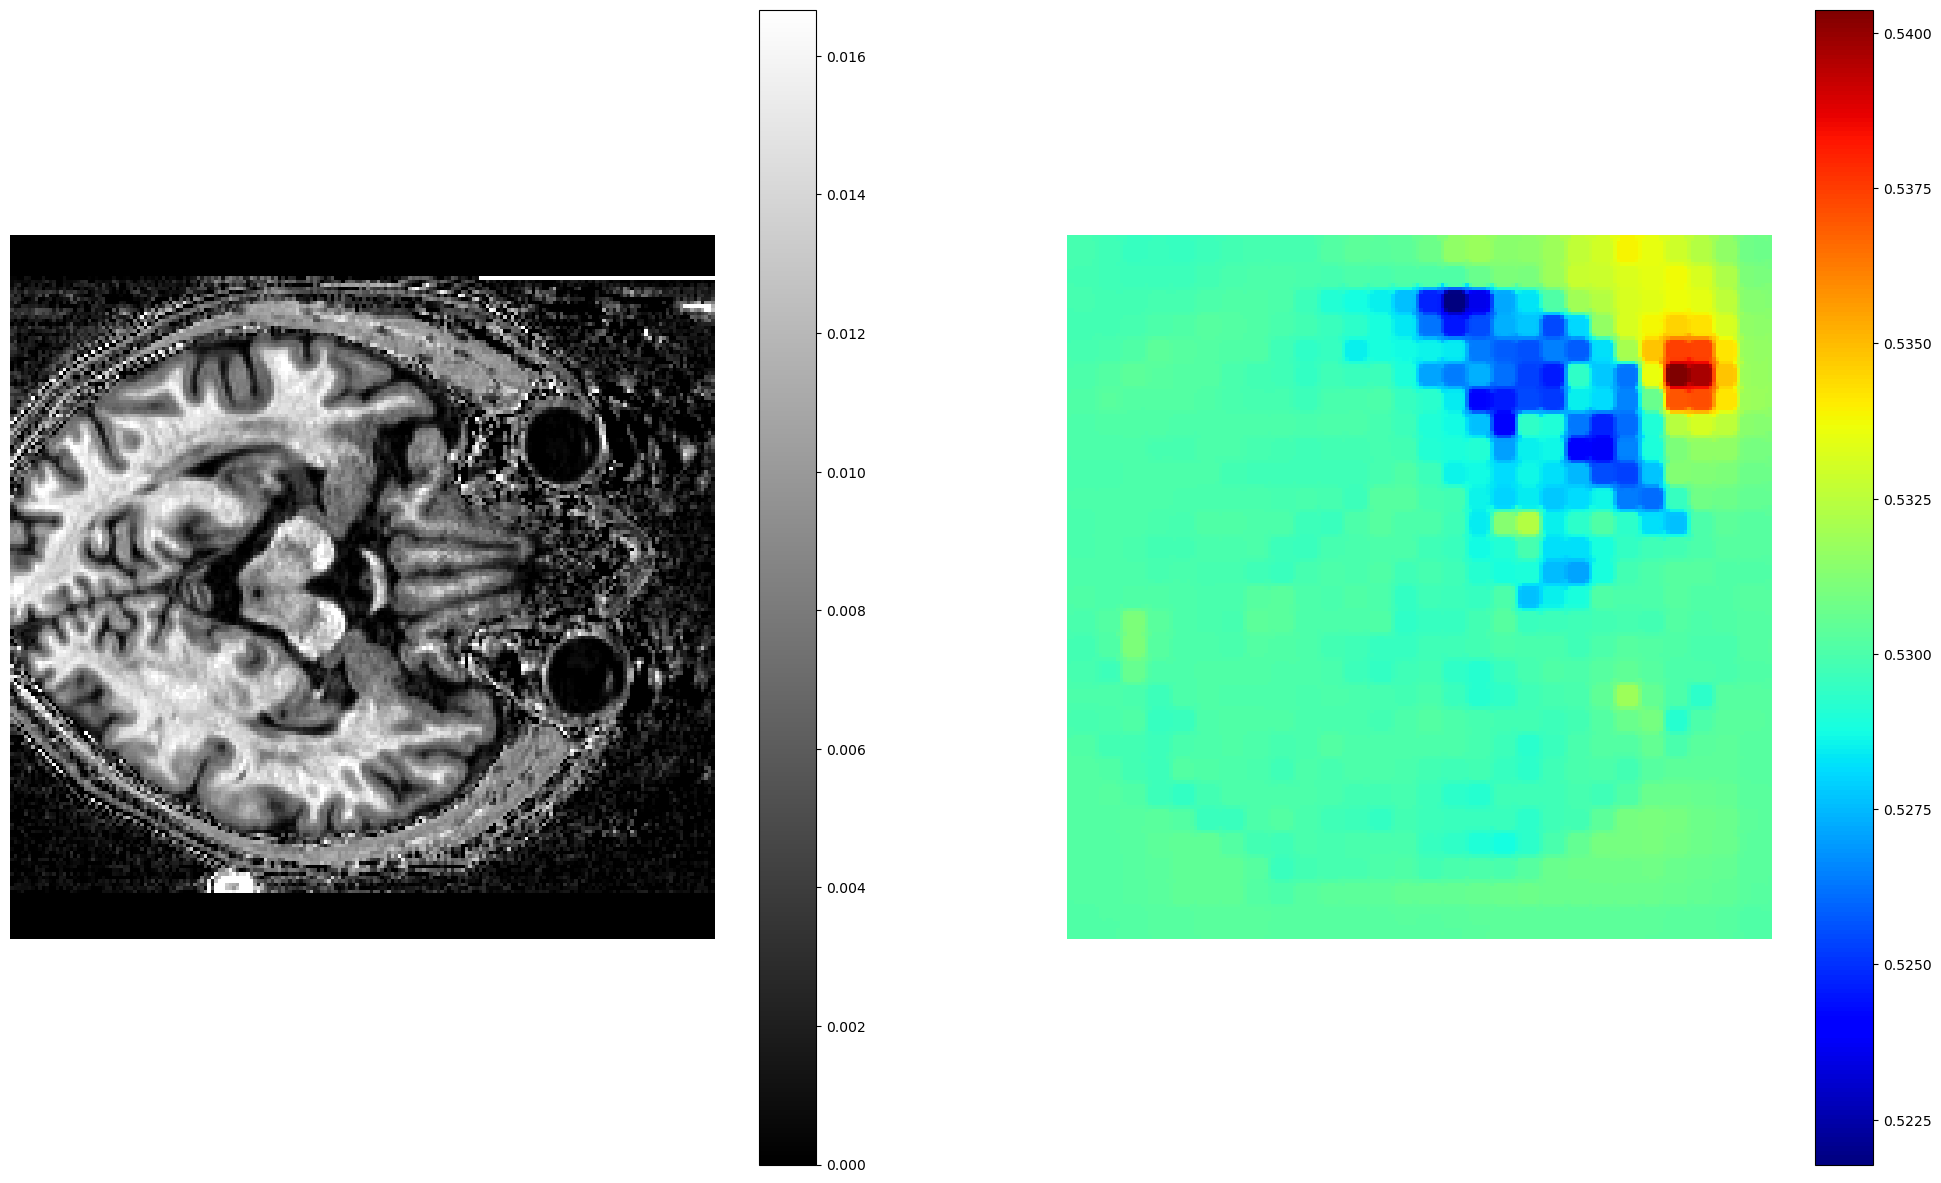

In [12]:
# label 1
occ_result_s = occ_result[0, 1][..., 0]
fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([pd_img[0, 0, ..., depth_slice].unsqueeze(0).unsqueeze(0), occ_result_s.unsqueeze(0).unsqueeze(0)]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)

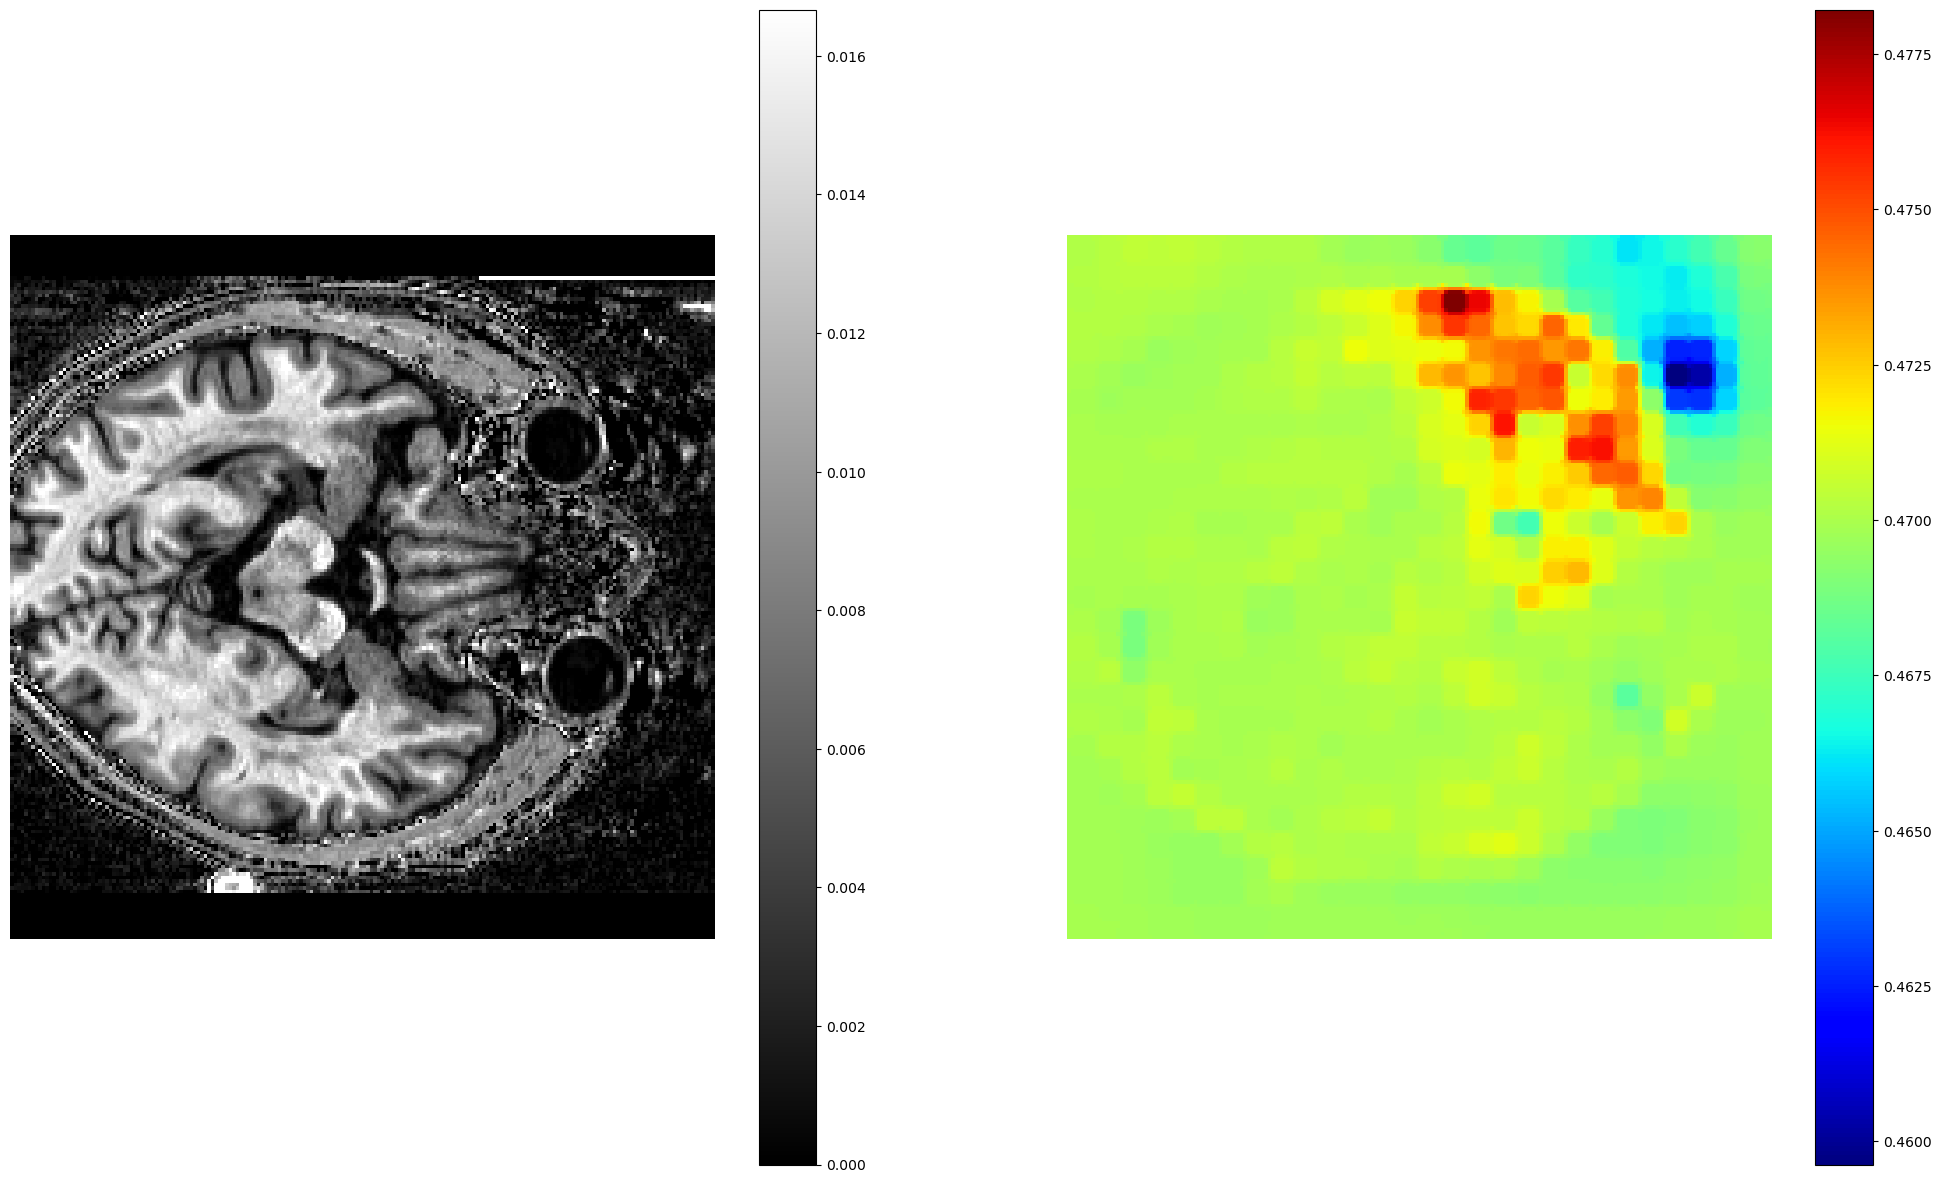

In [13]:
# label 0
occ_result_s = occ_result[0, 0][..., 0]
fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([pd_img[0, 0, ..., depth_slice].unsqueeze(0).unsqueeze(0), occ_result_s.unsqueeze(0).unsqueeze(0)]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)

In [20]:
# hC
# Get the occlusion sensitivity map
occ_sens = monai.visualize.OcclusionSensitivity(nn_module=model.net, mask_size=10, n_batch=10, overlap=0.25)
# Only get a single slice to save time.
# For the other dimensions (channel, width, height), use
# -1 to use 0 and img.shape[x]-1 for min and max, respectively
depth_slice = 80
occ_sens_b_box = [-1, -1, -1, -1, depth_slice - 1, depth_slice]

occ_result_hc, _ = occ_sens(x=hc_img, b_box=occ_sens_b_box)
# occ_result_s = occ_result[0, pd_label.argmax().item()][None]

100%|██████████| 85/85 [01:15<00:00,  1.13it/s]


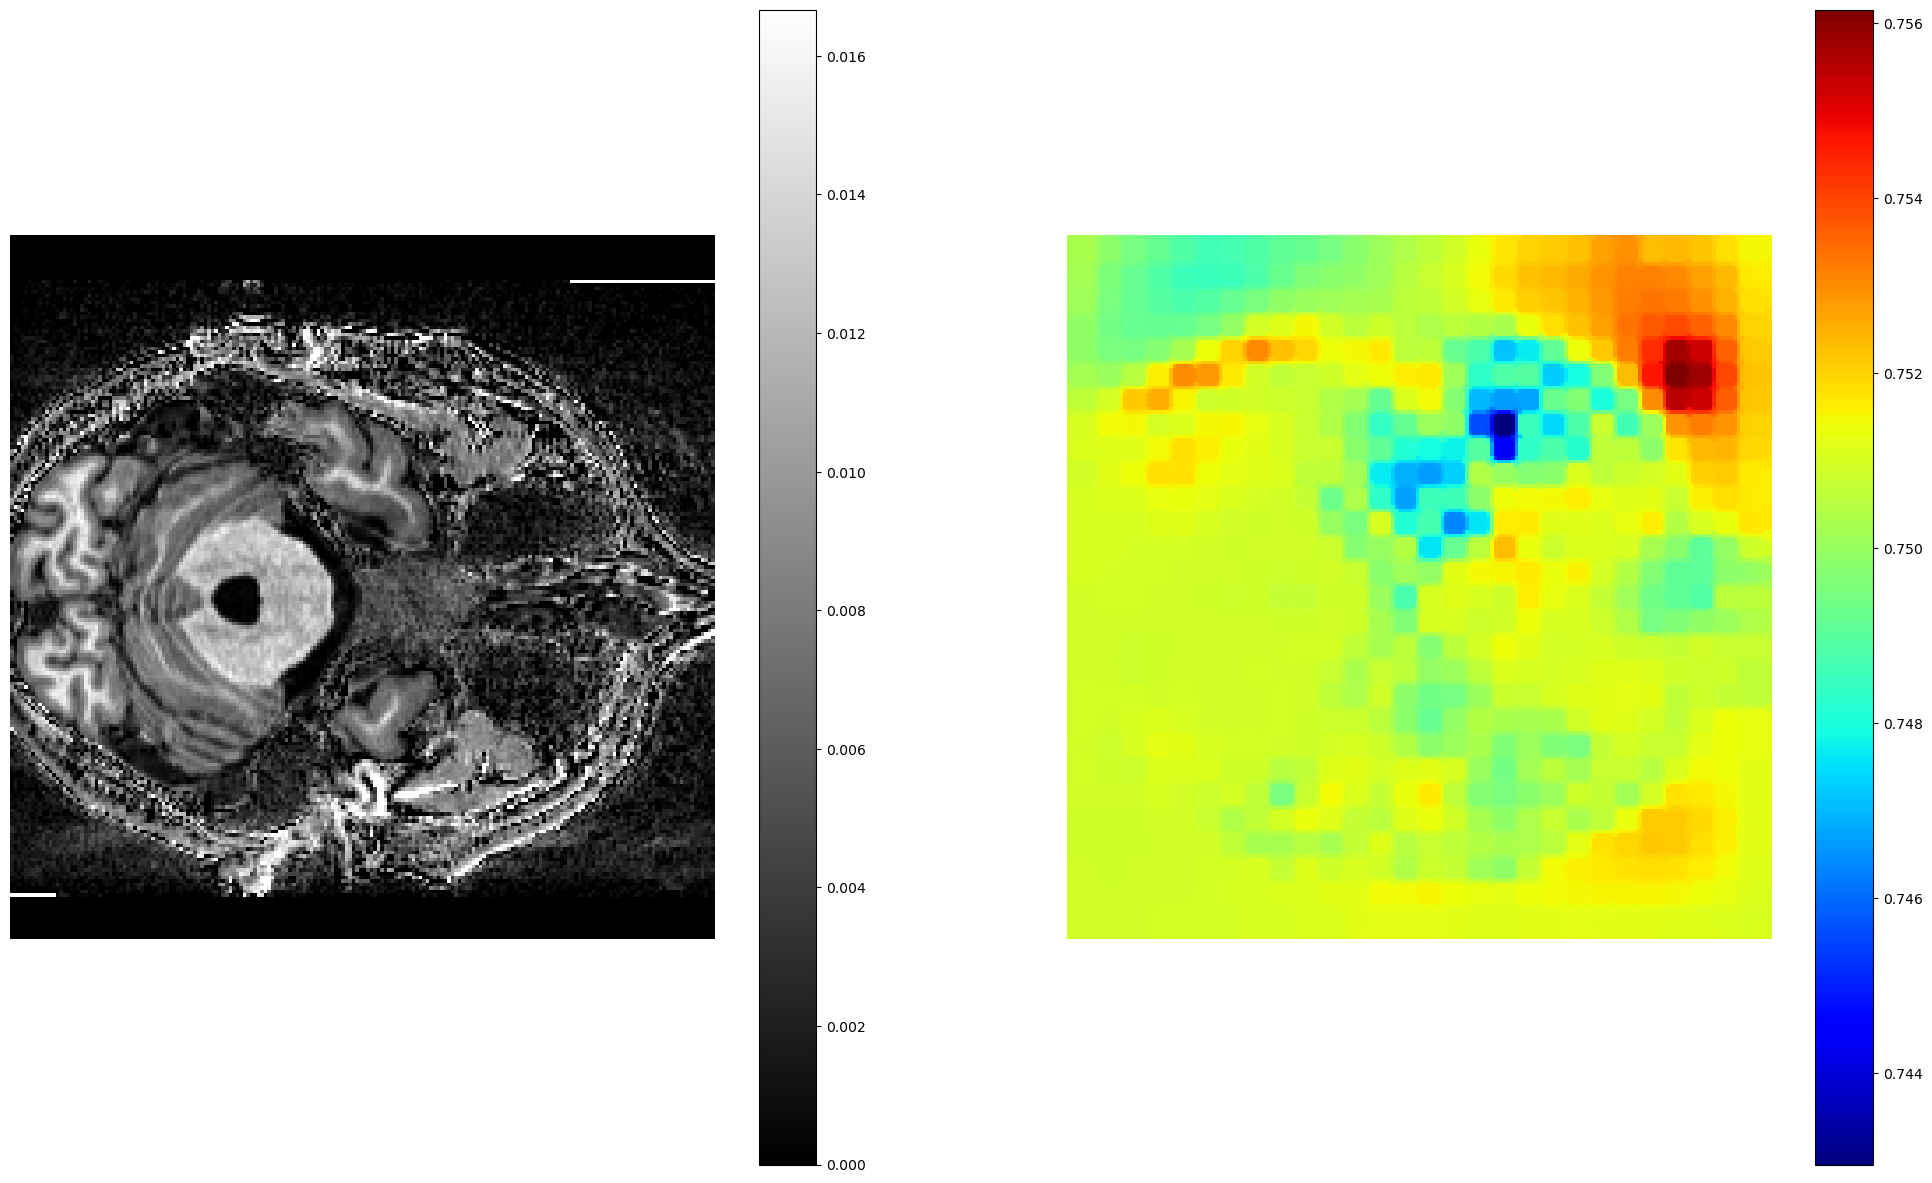

In [21]:
# label 1
occ_result_s = occ_result_hc[0, 1][..., 0]
fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([hc_img[0, 0, ..., depth_slice].unsqueeze(0).unsqueeze(0), occ_result_s.unsqueeze(0).unsqueeze(0)]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)

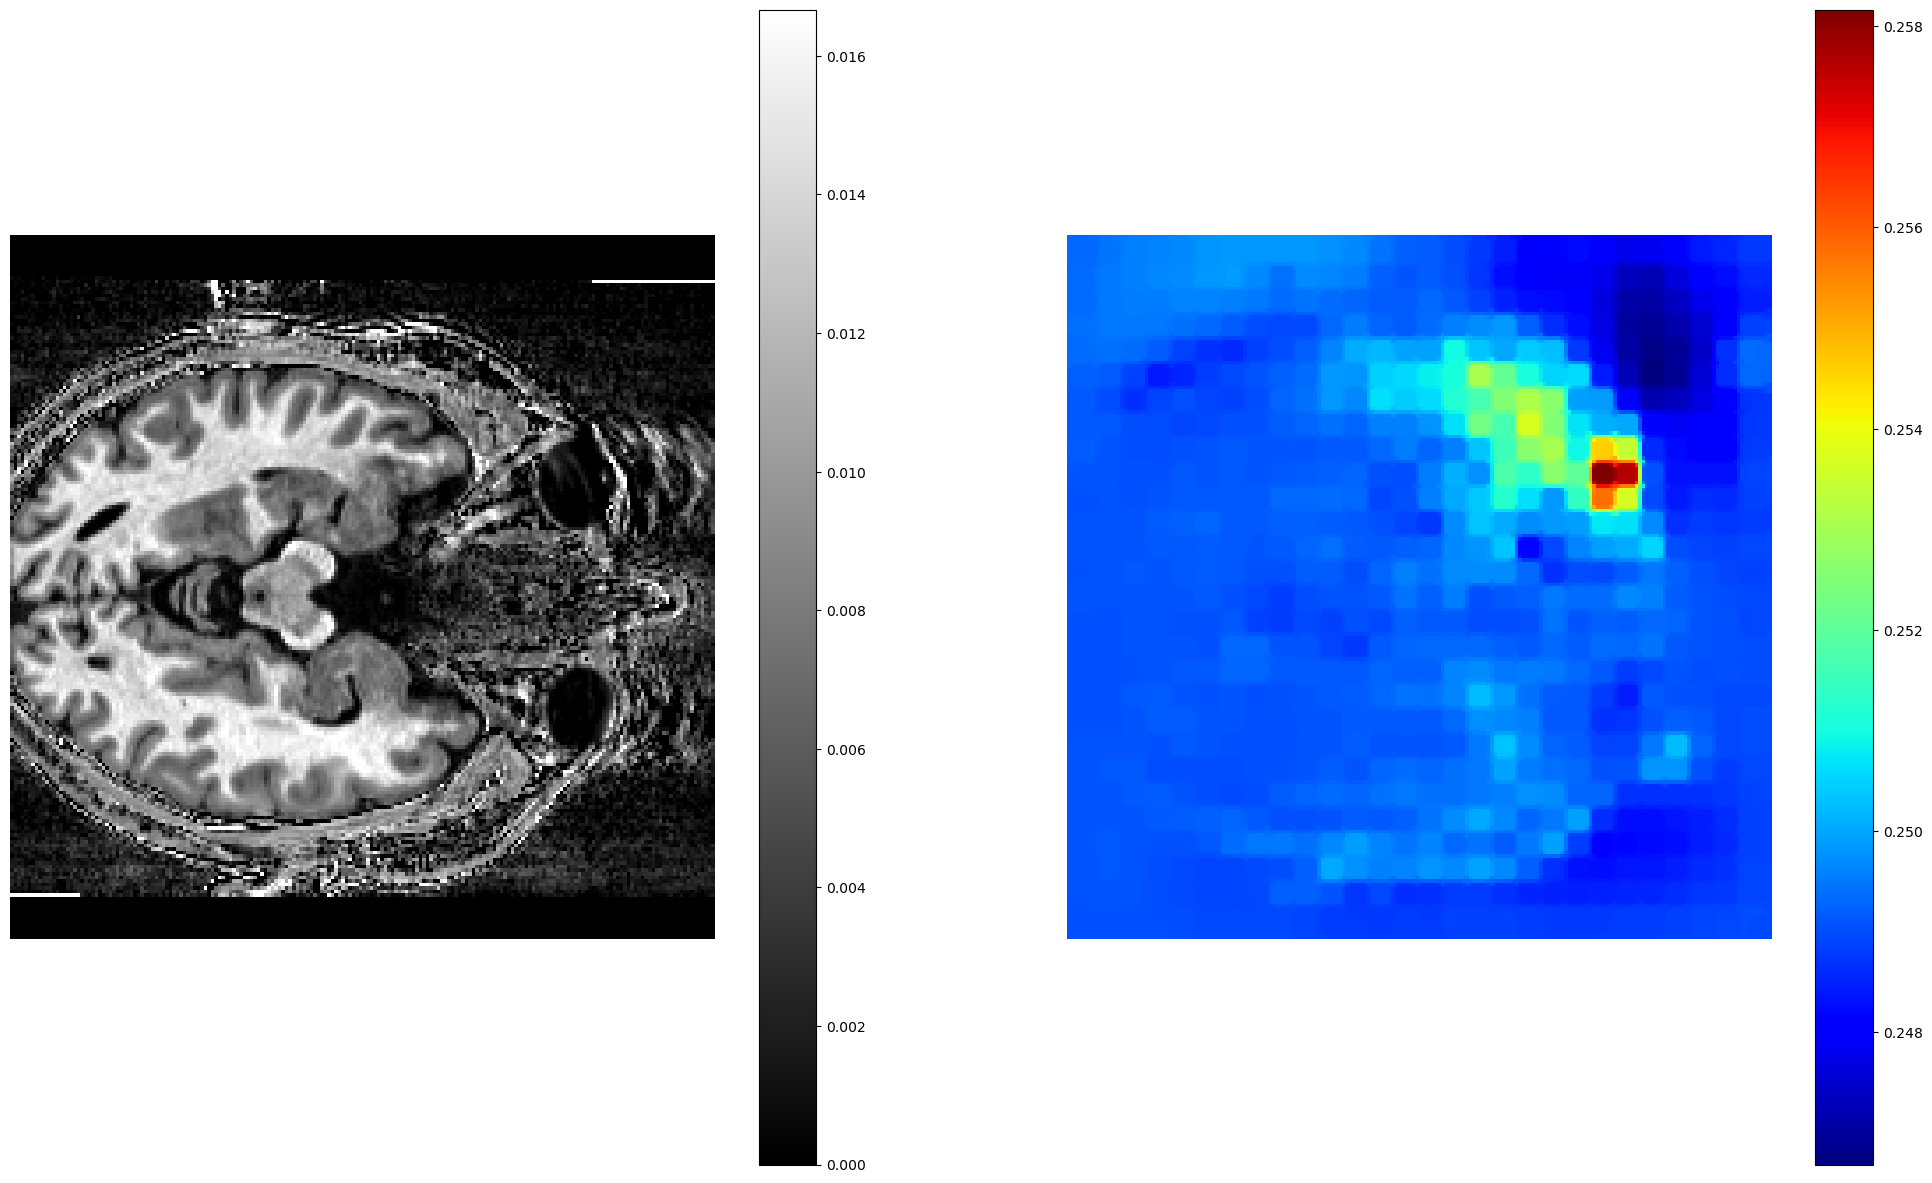

In [17]:
# label 0
occ_result_s = occ_result_hc[0, 0][..., 0]
fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([hc_img[0, 0, ..., depth_slice].unsqueeze(0).unsqueeze(0), occ_result_s.unsqueeze(0).unsqueeze(0)]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)